In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import LogFormatterSciNotation
import glob
from scipy.signal import blackmanharris
from scipy.stats import norm, gaussian_kde
import warnings
from scipy.linalg import toeplitz

## Setting up some constants for this particular data set

In [2]:
indir = "/lustre/aoc/projects/hera/kfchen/H4C/forMike"
outdir = "/lustre/aoc/projects/hera/mwilensk/inpaint_check"

files = glob.glob(f"{indir}/*")

freqs = np.append(np.linspace(48.14, 59.74, num=95), np.linspace(65.23, 85.96, num=265 - 95))

bounds = [0, 95, 180, 265]
delays = []
for bound_ind in range(3):
    freq_use = freqs[bounds[bound_ind]:bounds[bound_ind + 1]]
    delays.append(np.fft.fftfreq(len(freq_use), freq_use[1] - freq_use[0]) * int(1e3))
    
data_files = [file for file in files if "data" in file]
amat_files = [file for file in files if "amat" in file]

data_list = [np.load(file) for file in data_files]
data_arr = np.array(data_list)
print(f"data shape: {data_arr.shape}")
vis, weight, Tsys, hi, lo = data_arr.swapaxes(0, 1)
flags = np.logical_not(weight)

amat = np.load(amat_files[0])

print(f"amat shape: {amat.shape}")

data shape: (10, 5, 300, 265)
amat shape: (265, 71)


### Flagging mask examples on different nights

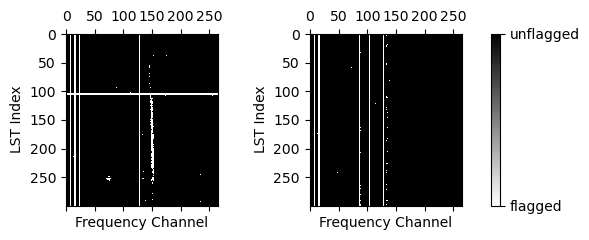

In [3]:
fig, ax = plt.subplots(figsize=(6.5, 2.5), ncols=2)
for nind in range(10):
    if nind < 2:
        im = ax[nind].matshow(weight[nind].real, cmap="binary")
        ax[nind].set_ylabel("LST Index")
        ax[nind].set_xlabel("Frequency Channel")
        if nind == 1:
            fig.tight_layout()
            cbar = fig.colorbar(im, ax=ax)
            cbar.ax.set_yticks([0, 1])
            cbar.ax.set_yticklabels(["flagged", "unflagged"])

fig.savefig(f"{outdir}/flag_pattern.pdf")


### Flag masks for all nights if interested

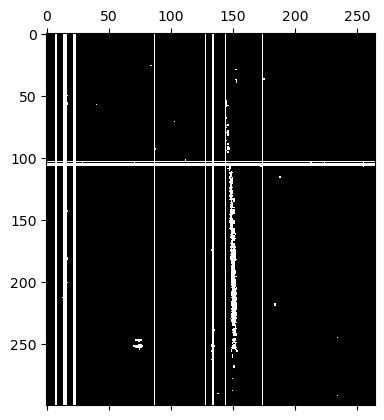

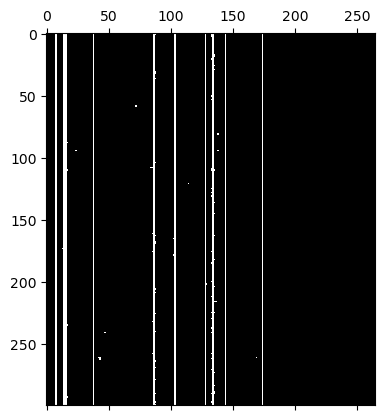

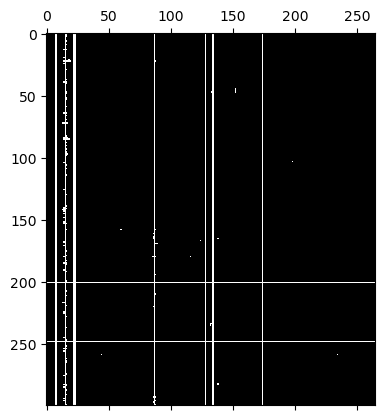

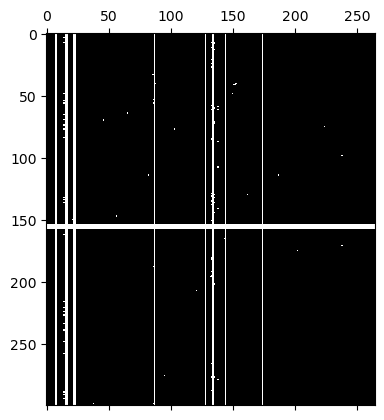

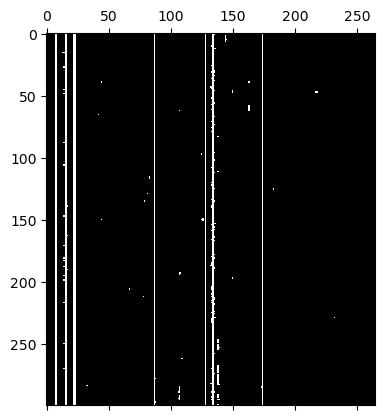

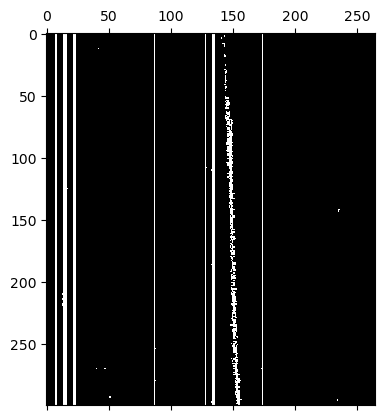

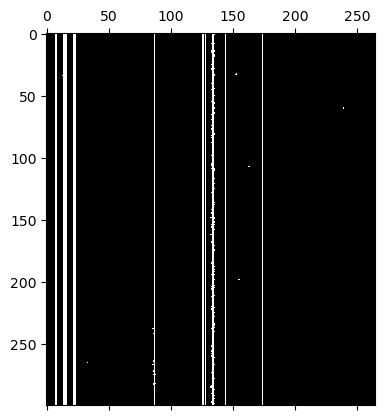

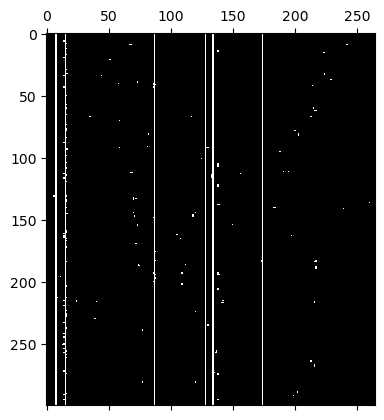

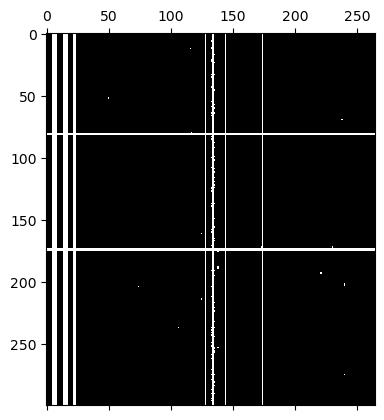

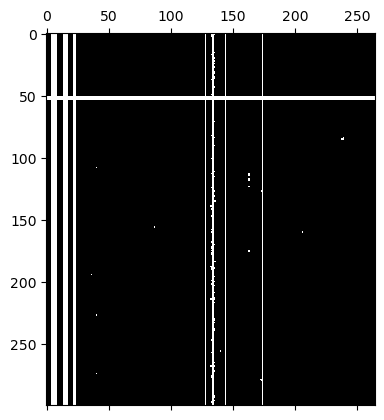

In [4]:
for nind in range(10):
    plt.matshow(weight[nind].real, cmap="binary")

### Plot of flagging rate per frequency, calculated over all nights/LSTs

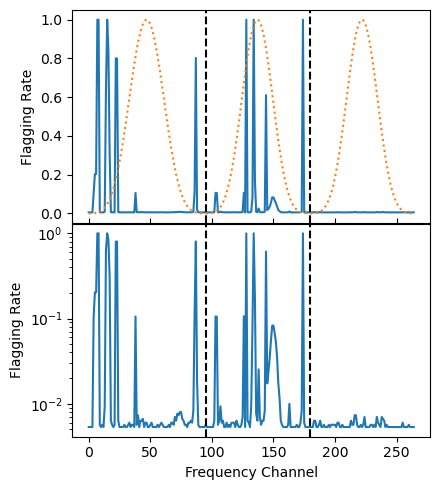

In [5]:
p = (np.count_nonzero(np.logical_not(weight), axis=(0, 1))) / (np.prod(weight.shape[:2]))

fig, ax = plt.subplots(figsize=(4.5, 5), nrows=2)
ax[0].plot(p)
ax[0].plot(blackmanharris(95), color="tab:orange", linestyle=":")
ax[0].plot(np.arange(95, 180), blackmanharris(85), color="tab:orange", linestyle=":")
ax[0].plot(np.arange(180, 265), blackmanharris(85), color="tab:orange", linestyle=":")
ax[1].plot(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("Frequency Channel")
ax[0].set_xlabel("")
ax[0].tick_params(axis="x", direction="in")
ax[0].set_xticklabels(())

for ax_ind in range(2):
    ax[ax_ind].set_ylabel("Flagging Rate")
    ax[ax_ind].axvline(95, linestyle="--", color="black")
    ax[ax_ind].axvline(180, linestyle="--", color="black")

fig.tight_layout(h_pad=0)


fig.savefig(f"{outdir}/flag_spectrum.pdf", bbox_inches="tight")

### Define a class that does all the important calculations

In [6]:
class inpaint_error_prop:
    """
    Class for propagating inpainting uncertainties.
    """
    
    def __init__(self, amat, vis, flags, Tsys, band_bounds, inv_noise_weight=False, add_noise=True):
        """
        Parameters:
            amat (array_like, complex): 
                Design matrix for the DPSS inpainter. Should be shape (Nfreqs, Nbasis).
            vis (array_like, complex): 
                Array of visibility waterfalls, shape (Nnights, Ntimes, Nfreqs).
            flags (array_like, bool): 
                Array of flags, shape (Nnights, Ntimes, Nfreqs)
            Tsys (array_like): 
                System temperature. We treat the square of this like the variance, but in reality
                we need more information such as integration time and bandwidth to apply the radiometer equation. 
                Shape (Nnights, Ntimes, Nfreqs).
            band_bounds (array_like, int):
                Frequency indices that denote analysis band edges
            inv_noise_weight (bool): 
                Whether to weight by the inverse noise variance (default False).
            add_noise (bool): 
                Whether to add the noise variance estimate to the inpainted channels (default True)
        """
        self.amat = amat
        self.Nfreqs = amat.shape[0]
        self.Nbasis = amat.shape[1]
        print(f"Inferred Nfreqs from amat: {self.Nfreqs}")
        print(f"Inferred Nbasis from amat: {self.Nbasis}")
        
        if vis.shape[-1] != self.Nfreqs:
            raise ValueError("vis shape incompatible with amat shape. Check frequency axis of vis.")
        if vis.dtype != complex:
            raise ValueError("vis not of complex data type. Check inputs.")
        self.vis = vis
        self.Nnights = vis.shape[0]
        self.Ntimes = vis.shape[1]
        print(f"Inferred Nnights from vis: {self.Nnights}")
        print(f"Inferred Ntimes from vis: {self.Ntimes}")
        
        if vis.shape != flags.shape:
            raise ValueError("vis and flags have different shape. Check inputs.")
        if flags.dtype != bool:
            raise TypeError("Flag array must be boolean. Check input and be sure you are not submitting weights.")        
        self.flags = flags
        
        if Tsys.shape != vis.shape:
            raise ValueError("vis and Tsys have different shape. Check inputs.")
        if Tsys.dtype != float:
            if Tsys.dtype != complex:
                raise ValueError("Tsys array is not of float or complex type. Check inputs.")
            else:
                warnings.warn("Tsys is complex. Casting to real. Check inputs if this is unexpected.")

        self.Tsys = Tsys.real
        self.var = self.Tsys**2
        
        self.band_bounds = band_bounds
        self.inv_noise_weight = inv_noise_weight
        self.add_noise = add_noise

        self.inp_ops = self.get_inp_ops()
        self.inp_covs, self.Tsys_inp = self.get_inp_covs()
        self.full_covs, self.diag_covs, self.simple_covs = self.get_delay_covs()
        
    def get_good_bad_freqs(self, night_ind, lst_ind):
        """
        Get boolean index arrays along the frequency axis for a specified night and lst.
        
        Parameters:
            night_ind (int): Index for the night in question.
            lst_ind (int): Index for the lst in question.
        """
        
        good_freqs = np.logical_not(self.flags)[night_ind, lst_ind]
        bad_freqs = self.flags[night_ind, lst_ind]

        return good_freqs, bad_freqs

    def get_inp_ops(self):
        """
        Get the inpainting operators based on the design matrix and a flag mask. 
        Can be inverse noise variance weighted. Each night and lst can in general have a different operator.
        
        Returns:
            inp_ops (list of list of complex array): The inpainting operator 
        """
        
    
        weights = 1 / self.var if self.inv_noise_weight else np.ones(self.vis.shape)
        
        # Just assume it's different every night and time. 
        # Might be faster to find unique flag masks and iterate over those, but flagging noise might foil you.
        inp_ops = []
        for night_ind in range(self.Nnights):
            inp_ops_night = []
            for lst_ind in range(self.Ntimes):
                
                good_freqs, bad_freqs = self.get_good_bad_freqs(night_ind, lst_ind)
                
                # Get right-most design matrix that talks to data, shape: Nunf, Nbasis
                amat_right = self.amat[good_freqs]
                
                # Left-most design matrix that fills in missing data
                amat_left = self.amat[bad_freqs]
                
                weights_use = weights[night_ind, lst_ind, good_freqs]
                AdagA = (amat_right.T.conj() * weights_use) @ amat_right
                
                # Silly way to skip doing an inverse
                lsq_op = np.linalg.solve(AdagA, amat_right.T.conj() * weights_use)
                
                # Section of operator that maps unflagged data to flagged data
                inp_op_fl = amat_left @ lsq_op

                num_unfl = np.count_nonzero(good_freqs)
                inp_op = np.zeros((self.Nfreqs, num_unfl), dtype=complex)

                inp_op[good_freqs] = np.eye(num_unfl)
                inp_op[bad_freqs] = inp_op_fl                
                inp_ops_night.append(inp_op)
            inp_ops.append(inp_ops_night)

        return inp_ops
    
    def get_inp_covs(self):
        """
        Get covariances after inpainting. Different one per night/lst. Just uses the square of the Tsys 
        as the variance, meaning it is in Tsys units (not normalized by sqrt(bandwidth * integration time).)
        
        Returns:
            inp_covs (array, complex): The freq-freq covariance per night/lst. 
        """
        
        inp_covs = []
        Tsys_inps = []
        for night_ind in range(self.Nnights):
            inp_covs_night = []
            Tsys_inp_night = []
            for lst_ind in range(self.Ntimes):
                good_freqs, bad_freqs = self.get_good_bad_freqs(night_ind, lst_ind)
                
                var_use = self.var[night_ind, lst_ind][good_freqs]
                inp_op = self.inp_ops[night_ind][lst_ind]
                
                inp_cov = (inp_op * var_use) @ inp_op.T.conj()
                if self.add_noise:
                    Tsys_use = Tsys[night_ind, lst_ind][good_freqs]
                    Tsys_inp = inp_op @ Tsys_use
                    Tsys_inp_night.append(Tsys_inp)
                    
                    inp_cov[bad_freqs, bad_freqs] += np.abs(Tsys_inp[bad_freqs])**2
                
                inp_covs_night.append(inp_cov)
            Tsys_inps.append(Tsys_inp_night)
            inp_covs.append(inp_covs_night)
            
        return np.array(inp_covs), np.array(Tsys_inps)
    
    def get_diag_delay_cov(self, diag_cov):
        """
        Make a delay covariance from a diagonal freq-freq covariance without doing a bunch of extra calculation
        
        Parameters:
            diag_cov (array_like, complex): 
                The array of covariances that are diagonal in frequency.  Shape (Ntimes, Nfreqs)
        Returns:
            diag_delay_cov (array_like, complex):
                Delay-delay covariance. Shape (Ntimes, Nfreqs, Nfreqs)
        """
        
        diag_delay_cov_col = np.fft.fft(diag_cov, axis=1)
        
        diag_delay_cov = [toeplitz(diag_delay_cov_col[time_ind]) for time_ind in range(self.Ntimes)]
        
        return np.array(diag_delay_cov)
    
    def get_delay_covs(self):
        """
        Get the three delay covariances (full propagation, diagonal terms only, simple method)
        
        Parameters:
            slc (slice): slice into frequency axis for the fft
        
        Returns:
            full_covs (array_like, complex): 
                The full delay-delay covariance at each LST
            diag_covs (array_like, complex):
                The delay-delay covariance obtained by ignoring freq-freq correlations (variance only calculation)
            simple_covs (array_like, complex):
                The delay-delay covariance obtained by assuming zero information is gained through inpainting.
                
            
        """
        good_dat = np.logical_not(self.flags)
        
        full_covs_freq = self.inp_covs.sum(axis=0) / self.Nnights**2
        diag_covs_freq = full_covs_freq[:, np.arange(self.Nfreqs), np.arange(self.Nfreqs)]
        
        num_good_night = np.count_nonzero(good_dat, axis=0)
        ngn_gt_0 = num_good_night > 0
        
        #Fill in unsampled freqs/lsts with max inpainted variance in that bin (no night divisor)
        simple_covs_nans = (self.var * good_dat).sum(axis=0) / num_good_night**2
        simple_covs_freq = np.where(ngn_gt_0, simple_covs_nans, np.amax(np.abs(self.Tsys_inp)**2, axis=0))
        
        band_bounds_full = np.append(0, np.append(self.band_bounds, self.Nfreqs))
        Nbands = len(self.band_bounds) + 1
        
        full_covs = []
        diag_covs = []
        simple_covs = []
        for band_ind in range(Nbands):
            slc = slice(band_bounds_full[band_ind], band_bounds_full[band_ind + 1])
            taper = blackmanharris(slc.stop - slc.start)
        
            full_cov = np.fft.fft(np.fft.fft(full_covs_freq[:, slc][:, :, slc] * np.outer(taper, taper), 
                                             axis=1).swapaxes(1, 2).conj(), 
                                  axis=1).swapaxes(1, 2).conj()
            diag_cov = self.get_diag_delay_cov(diag_covs_freq[:, slc] * taper**2)
            simple_cov = self.get_diag_delay_cov(simple_covs_freq[:, slc] * taper**2)
            
            full_covs.append(full_cov)
            diag_covs.append(diag_cov)
            simple_covs.append(simple_cov)

        
        return full_covs, diag_covs, simple_covs
                
    


### Create an instance and calculate all the covs

In [7]:
iep = inpaint_error_prop(amat, vis, flags, Tsys.real, (95, 180))

Inferred Nfreqs from amat: 265
Inferred Nbasis from amat: 71
Inferred Nnights from vis: 10
Inferred Ntimes from vis: 300


/tmp/ipykernel_175015/19949603.py:205: RuntimeWarning: invalid value encountered in divide
  simple_covs_nans = (self.var * good_dat).sum(axis=0) / num_good_night**2


### Plot an example of inpainted variances from one night/lst

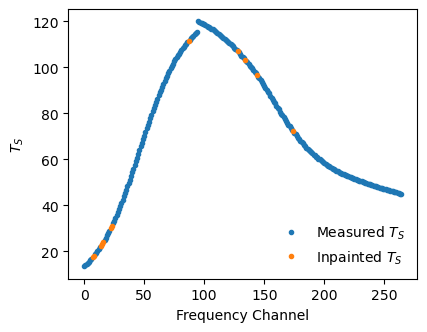

In [8]:
night_ind = 0
lst_ind = 0

Tsys_demo = Tsys[night_ind, lst_ind]
bad_freqs = flags[night_ind, lst_ind]
good_freqs = np.logical_not(bad_freqs)

meas_Tsys = Tsys_demo[good_freqs].real
inp_Tsys = (iep.inp_ops[night_ind][lst_ind] @ Tsys_demo[good_freqs])[bad_freqs].real

fig, ax = plt.subplots(figsize=(4.5, 3.5))
ax.plot(np.where(good_freqs)[0], meas_Tsys, label=r"Measured $T_S$", linestyle="none", marker=".")
ax.plot(np.where(bad_freqs)[0], inp_Tsys, 
        label="Inpainted $T_S$", linestyle="None", marker=".")
ax.set_ylabel("$T_{S}$")
ax.set_xlabel("Frequency Channel")
ax.legend(frameon=False, loc="lower right")

fig.savefig(f"{outdir}/TS_init_newcode.pdf", bbox_inches="tight")

### Plot some example covariance matrices

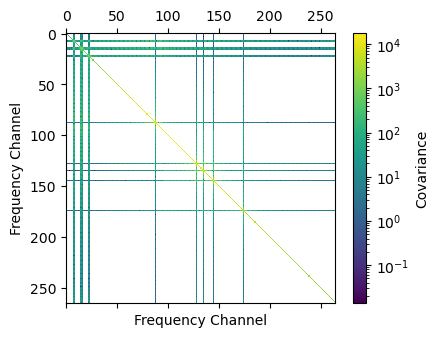

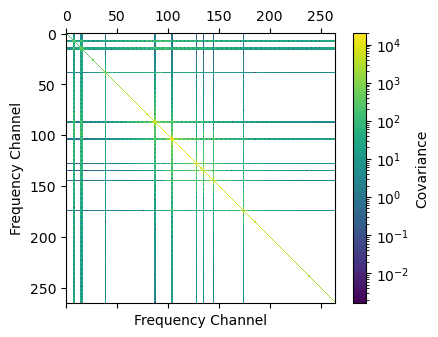

In [9]:


def cov_plot(cov, fn, night_ind=0, lst_ind=0):

    fig, ax = plt.subplots(figsize=(4.5, 3.5))
    im = ax.matshow(np.abs(cov[night_ind][lst_ind]), norm=colors.LogNorm())
    cbar = fig.colorbar(im, ax=ax)
    ax.set_ylabel("Frequency Channel")
    ax.set_xlabel("Frequency Channel")
    cbar.ax.set_ylabel("Covariance")

    fig.savefig(f"{outdir}/{fn}_night{night_ind}_.pdf")
    
    return

cov_plot(iep.inp_covs, f"cov_example", night_ind=0, lst_ind=0)
cov_plot(iep.inp_covs, f"cov_example", night_ind=1, lst_ind=3)

### Plot the diagonals of a freq-freq covariance

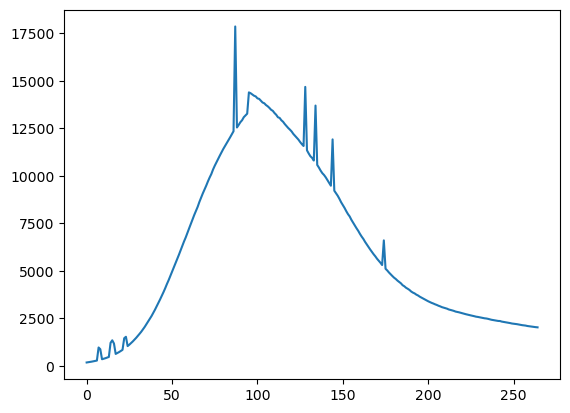

In [10]:
plt.plot(iep.inp_covs[0][0][range(265), range(265)].real)

### Plot the delay PS variances for one lst/band combo. The PS variance is the mod square of the delay-transformed vis. variance (which is what is calculated in the class), under the assumption that the PS is made from two independent baselines with the exact same delay-delay covariance

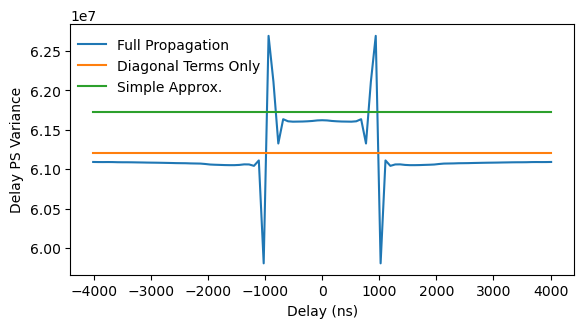

In [37]:
plt.figure(figsize=(6.5, 3.25))

band_ind = 0
lst_ind = 0

names = ["Full Propagation", "Diagonal Terms Only", "Simple Approx."]
cov_types = ["full_covs", "diag_covs", "simple_covs"]

for type_ind in range(3):
    cov_use = getattr(iep, cov_types[type_ind])[band_ind][lst_ind]
    cov_plot = np.fft.fftshift(np.abs(np.diag(cov_use))**2)

    plt.plot(np.fft.fftshift(delays[band_ind]), cov_plot, 
             label=names[type_ind])

plt.xlabel("Delay (ns)")
plt.ylabel("Delay PS Variance")
plt.legend(loc=[0.005, 0.7], frameon=False, fontsize=10)
plt.yscale("linear")


### Plot some of the PS covariances for comparison

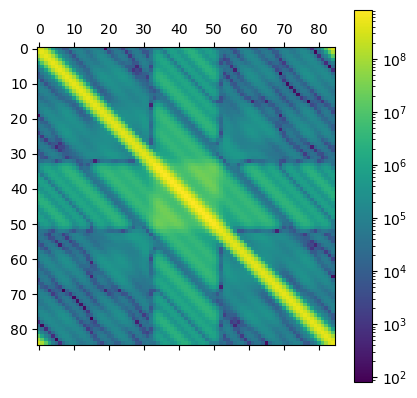

In [40]:
def plot_PS_cov(cov_type="full_covs", band_ind=1, lst_ind=1):
    cov = getattr(iep, cov_type)[band_ind][lst_ind]
    PS_cov = np.fft.fftshift(np.abs(cov)**2, axes=(0, 1))

    plt.matshow(PS_cov, norm=colors.LogNorm())
    plt.colorbar()
    
    return

plot_PS_cov()

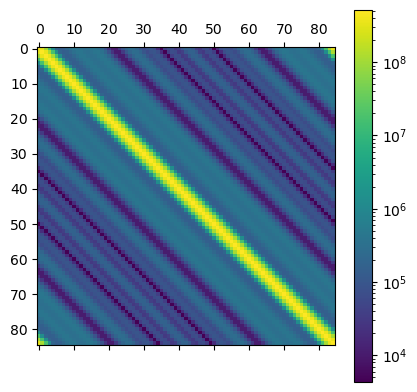

In [41]:
plot_PS_cov(cov_type="diag_covs")

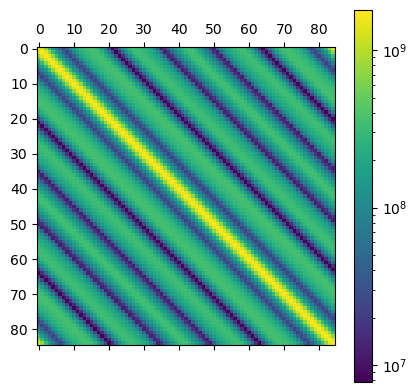

In [42]:
plot_PS_cov(cov_type="simple_covs")

### Plot vars per LST. Band 1 is highly flagged, so the "simple" approx can make the variance a factor of ~6 higher in some cases. Band 0 is lightly flagged, and has a few LSTs at ~0.6 for the simple approx. Band 2 is very lightly flagged, so the two cases mix a bit and are close to 0 everywhere. Importantly, I have only seen the diagonal approximation be greater than the simple approximation at a given LST to floating point error level.

/tmp/ipykernel_175015/1877571576.py:24: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax[band_ind].axhline(y=0, color="black", linestyle=":")


Text(0.5, 0, 'Delay (ns)')

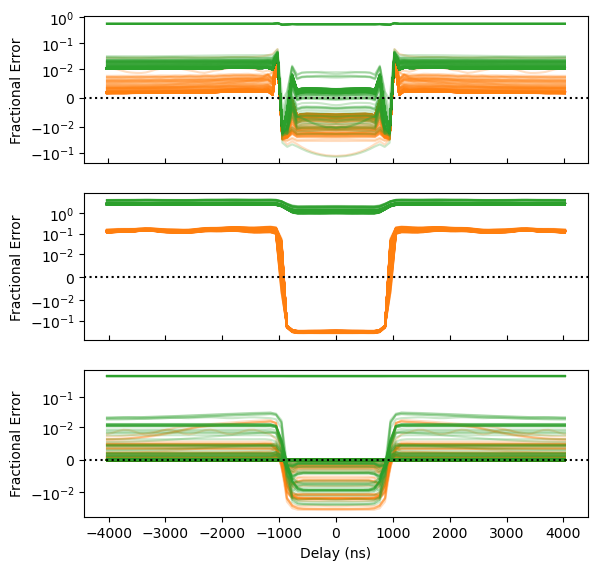

In [68]:
fig, ax = plt.subplots(nrows=3, figsize=(6.5, 6.5))

for band_ind in range(3):
    full_cov = np.fft.fftshift(iep.full_covs[band_ind], axes=(1, 2))
    diag_cov = np.fft.fftshift(iep.diag_covs[band_ind], axes=(1, 2))
    simple_cov = np.fft.fftshift(iep.simple_covs[band_ind], axes=(1, 2))


    diag_inds = np.diag_indices(full_cov.shape[-1])

    full_var = np.abs(full_cov[:, diag_inds[0], diag_inds[1]])**2
    diag_var = np.abs(diag_cov[:, diag_inds[0], diag_inds[1]])**2
    simple_var = np.abs(simple_cov[:, diag_inds[0], diag_inds[1]])**2
    
    diag_frac = diag_var / full_var - 1
    simple_frac = simple_var / full_var - 1
    
    
    ax[band_ind].plot(np.fft.fftshift(delays[band_ind]), diag_frac.T, color="tab:orange", alpha=0.25)
    ax[band_ind].plot(np.fft.fftshift(delays[band_ind]), simple_frac.T, color="tab:green", alpha=0.25)
    
    ax[band_ind].set_ylabel("Fractional Error")
    ax[band_ind].set_yscale("symlog", linthresh=1e-2)
    ax[band_ind].axhline(y=0, color="black", linestyle=":")
    if band_ind < 2:
        ax[band_ind].set_xticklabels([])
        ax[band_ind].tick_params(axis="x", direction="in")

ax[2].set_xlabel("Delay (ns)")

